# Air Mass RGB (RGB example using non-reprojected IR channels)
This jupyter notebook shows how to make a sub-region plot of air mass RGB composition. This is an example of RGB composition using non-reprojected IR channels of GOES-16. \
**Warning: if your RAM is less than 8GB it is recommended to work with a small domain.**

Import the GOES package.

In [1]:
import GOES

Set path and name of file that will be read.

In [2]:
path = '/home/joao/Downloads/GOES-16/ABI/'
C08_file = 'OR_ABI-L2-CMIPF-M6C08_G16_s20200782000176_e20200782009484_c20200782009572.nc'
C10_file = 'OR_ABI-L2-CMIPF-M6C10_G16_s20200782000176_e20200782009496_c20200782009566.nc'
C12_file = 'OR_ABI-L2-CMIPF-M6C12_G16_s20200782000176_e20200782009490_c20200782009567.nc'
C13_file = 'OR_ABI-L2-CMIPF-M6C13_G16_s20200782000176_e20200782009496_c20200782010003.nc'

Reads the file.

In [3]:
C08_ds = GOES.open_dataset(path+C08_file)
C10_ds = GOES.open_dataset(path+C10_file)
C12_ds = GOES.open_dataset(path+C12_file)
C13_ds = GOES.open_dataset(path+C13_file)

Set the map domain.

In [4]:
domain = [-90.0,-30.0,-60.0,15.0]

Gets image with the coordinates of corners of their pixels.

In [5]:
C08, LonCor, LatCor = C08_ds.image('CMI', lonlat='corner', domain=domain)

Gets the **pixels_limits** parameter of C08. This parameter will be used in the other channels to obtain an imagen with the same domain than C08.

In [6]:
domain_in_pixels = C08.pixels_limits

Creates a nan's mask with C08 to get the image of the other channels.

In [7]:
import numpy as np
mask = np.where(np.isnan(C08.data)==True, True, False)

Gets the image of channel 10, 12 and 13 with the same coverage areas as channel 08.

In [8]:
C10, _, _ = C10_ds.image('CMI', lonlat='none', domain_in_pixels=domain_in_pixels, nan_mask=mask)
C12, _, _ = C12_ds.image('CMI', lonlat='none', domain_in_pixels=domain_in_pixels, nan_mask=mask)
C13, _, _ = C13_ds.image('CMI', lonlat='none', domain_in_pixels=domain_in_pixels, nan_mask=mask)

Gets information about data.

In [9]:
sat = C08_ds.attribute('platform_ID')
time = C08_ds.variable('time_bounds').data[0]

Defines the name of product.

In [10]:
product = 'Air mass RGB'

Makes the RGB composition.

In [11]:
import numpy as np

# defines R, G and B channels
R = C08.data - C10.data
G = C12.data - C13.data
B = C08.data - 273.15

# set limits of channels
Rmin, Rmax = -26.2, 0.6
Gmin, Gmax = -43.2, 6.7
Bmin, Bmax = -64.65, -29.25
R = np.clip(R, Rmin, Rmax)
G = np.clip(G, Gmin, Gmax)
B = np.clip(B, Bmin, Bmax)

# normalize channels
R = (R-Rmin)/(Rmax-Rmin)
G = (G-Gmin)/(Gmax-Gmin)
B = (B-Bmin)/(Bmax-Bmin)

# perform the gamma correction
R_gamma, G_gamma, B_gamma = 1, 1, 1
R = np.power(R, 1/R_gamma)
G = np.power(G, 1/G_gamma)
B = np.power(B, 1/B_gamma)

# invert the channel
B = 1.0 - B

# stack channels
RGB = np.dstack((R, G, B)).astype(np.float16)

# reshape the RGB array from 2D to 1D
RGB = RGB.reshape((RGB.shape[0]*RGB.shape[1],RGB.shape[2]))

# ensures RGB data is between 0 and 1
RGB = np.clip(RGB, 0.0, 1.0, dtype=RGB.dtype)

# creates a simple array to make the plot with pcolormesh
mask = np.where(mask==True,np.nan, 1).astype(np.float16)

Deletes unnecessary data.

In [12]:
del C08, C10, C12, C13, R, G, B

Creates plot.

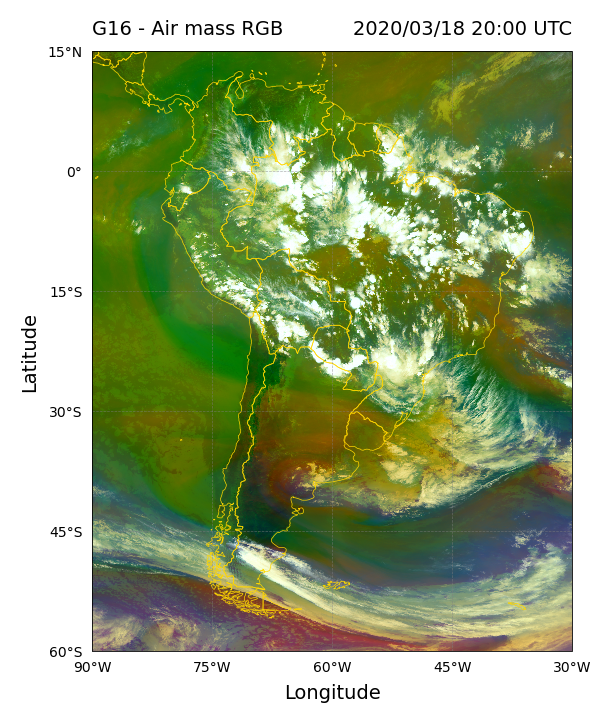

In [13]:
# import packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# calculates the central longitude of the plot
lon_cen = 360.0+(domain[0]+domain[1])/2.0

# creates the figure
fig = plt.figure('map', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.16, 0.80, 0.75], projection=ccrs.PlateCarree(lon_cen))
ax.outline_patch.set_linewidth(0.3)

# add the geographic boundaries
l = NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax.add_feature(l, edgecolor='gold', linewidth=0.25)

# plot the data
img = ax.pcolormesh(LonCor.data, LatCor.data, mask, transform=ccrs.PlateCarree(), color=RGB)

# set the title
ax.set_title('{} - {}'.format(sat, product), fontsize=7, loc='left')
ax.set_title(time.strftime('%Y/%m/%d %H:%M UTC'), fontsize=7, loc='right')

# Sets X axis characteristics
dx = 15
xticks = np.arange(domain[0], domain[1]+dx, dx)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(dateline_direction_label=True))
ax.set_xlabel('Longitude', color='black', fontsize=7, labelpad=3.0)

# Sets Y axis characteristics
dy = 15
yticks = np.arange(domain[2], domain[3]+dy, dy)
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_ylabel('Latitude', color='black', fontsize=7, labelpad=3.0)

# Sets tick characteristics
ax.tick_params(left=True, right=True, bottom=True, top=True,
               labelleft=True, labelright=False, labelbottom=True, labeltop=False,
               length=0.0, width=0.05, labelsize=5.0, labelcolor='black')

# Sets grid characteristics
ax.gridlines(xlocs=xticks, ylocs=yticks, alpha=0.6, color='gray',
             draw_labels=False, linewidth=0.25, linestyle='--')

# set the map limits
ax.set_extent([domain[0]+360.0, domain[1]+360.0, domain[2], domain[3]], crs=ccrs.PlateCarree())

plt.show()